# 2D Ising Model
## Packages and Config

In [127]:
include("Ising.jl");
using Plots, Plots.PlotMeasures, LaTeXStrings, DataFrames, CSV
using StatsBase: autocor
using LsqFit: curve_fit, coef

figpath = "fig/"
animpath = "anim/"
framepath = animpath * "frames/"
datapath = "data/2d/"

Plots.default(titlefontsize=18, tickfontsize=10, labelfontsize=14, legendfontsize=10,
    size=(600, 450), lw=3, ms=4, fontfamily="Computer Modern")

In [3]:
βmin, βmax, βcount = 0.1, 0.8, 51
βs = collect(range(βmin, βmax, length=βcount))
sidelen = 512

512

## Spin Visualization

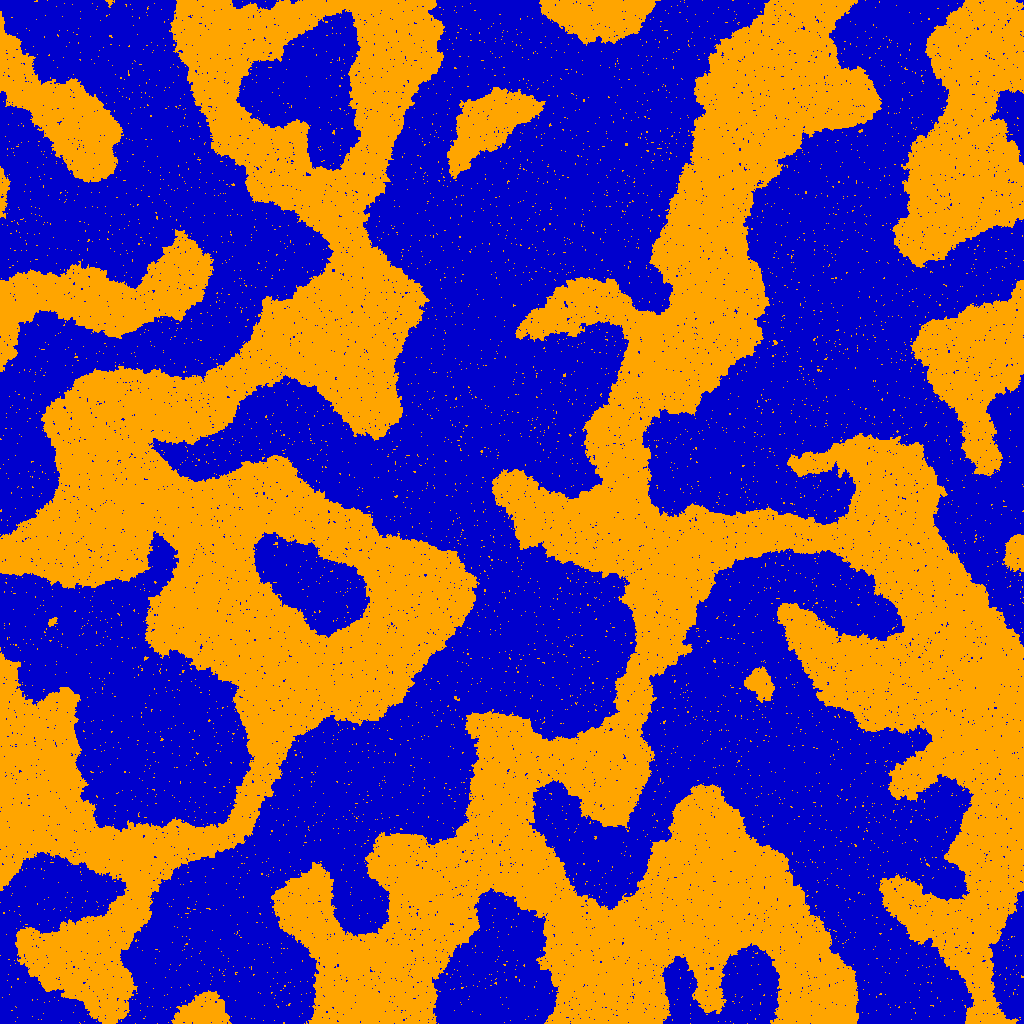

In [85]:
β = 0.6
isingmodel = Ising.IsingModel(β, 1024, 1024)
Ising.simulate!(isingmodel, 200)

heat = heatmap(isingmodel.spins, color=cgrad([:orange, :mediumblue]), legend=false,
        size=(1024, 1024), showaxis=false, ticks=false, margin=-2mm)
savefig(figpath * "vis-$(round(β, digits=2)).png")
display(heat)

## Animation

┌ Info: Saved animation to 
│   fn = d:\University\Computational Physics\Assignments\ps8-ising-model\anim\512-0.5.gif
└ @ Plots C:\Users\SLHHe\.julia\packages\Plots\DVjvF\src\animation.jl:114


Plots.AnimatedGif("d:\\University\\Computational Physics\\Assignments\\ps8-ising-model\\anim\\512-0.5.gif")
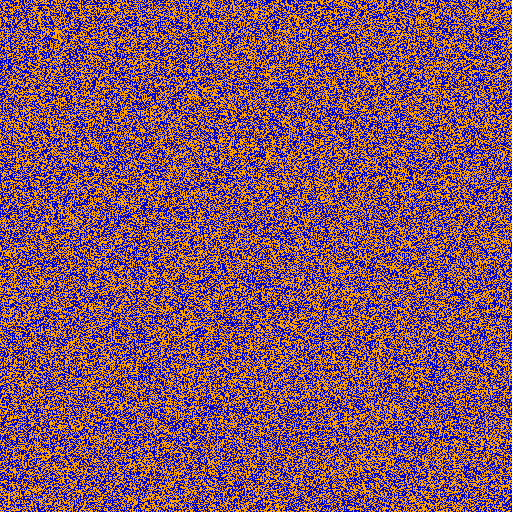

In [19]:
β = 0.5
isingmodel = Ising.IsingModel(β, sidelen, sidelen)

# initialize animation
anim = Animation(framepath, String[])

# draw frames
for i in 1:150
    heat = heatmap(isingmodel.spins, color=cgrad([:orange, :mediumblue]), legend=false,
        size=(sidelen, sidelen), showaxis=false, ticks=false, margin=-2mm)
        # for some reason you need negative margins to fill the whole area :/
    frame(anim, heat)
    Ising.update!(isingmodel)
end

gif(anim, animpath * "$sidelen-$(round(β, digits=2)).gif", fps=15)

## Relaxation Time

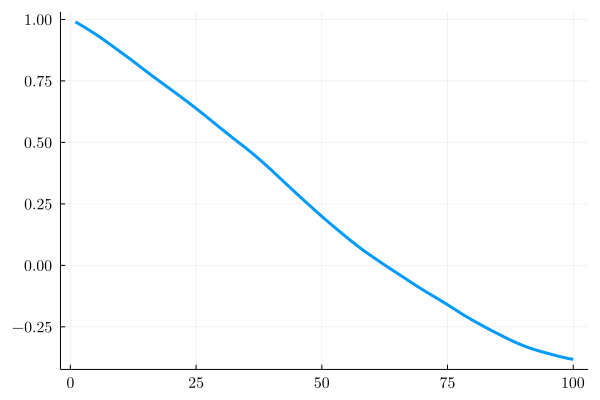

In [70]:
isingmodel = Ising.IsingModel(βmax, sidelen, sidelen)
energy, magnetization = Ising.simulate!(isingmodel, 200, fullstats=true)
autocorrelation = autocor(magnetization, 1:100)
plot(autocorrelation)

## Correlation Length

In [142]:
relaxtime = 2000
runtime = 100

βi = collect(range(0.5, 0.8, length=21))
corr = zeros(βcount)
for i in 1:βcount
    isingmodel = Ising.IsingModel(βs[i], 128, 128)
    Ising.simulate!(isingmodel, relaxtime)
    
    for _ in 1:runtime
        Ising.update!(isingmodel)
        cl = Ising.corlen(isingmodel)
        # if cl > 100
        #     display(plot(Ising.correlation(isingmodel)))
        #     #display(heatmap(isingmodel.spins))
        #     println(βi[i])
        # end
        corr[i] += cl / runtime
    end
end

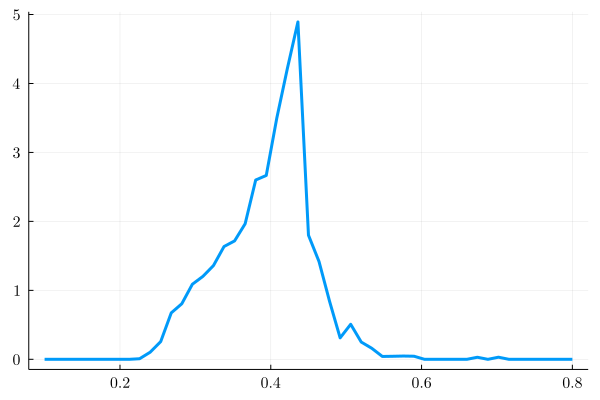

In [141]:
plot(βs, corr)

## Statistics

In [4]:
runtime = 1000
relaxtime = runtime / 10

Ēs, m̄s, Ē²s, m̄²s = [Float64[] for i in 1:4]

for β in βs
    isingmodel = Ising.IsingModel(β, sidelen, sidelen)
    # evolve the system to equilibrium
    Ising.simulate!(isingmodel, relaxtime)
    # take data
    Ē, m̄, Ē², m̄² = Ising.simulate!(isingmodel, runtime)
    push!(Ēs, Ē)
    push!(Ē²s, Ē²)
    push!(m̄s, m̄)
    push!(m̄²s, m̄²)
end

# save data to file
df = DataFrame(
    "beta" => βs,
    "mean energy" => Ēs, "mean mag" => m̄s,
    "mean sq energy" => Ē²s, "mean sq mag" => m̄²s)
CSV.write("temp/full$sidelen.csv", df)

peak = argmax(@. βs ^ 2 * (Ē²s - Ēs ^ 2))
βzoom = collect(range(βs[peak] - 0.05, βs[peak] + 0.05, length=βcount))
Ēs, m̄s, Ē²s, m̄²s = [Float64[] for i in 1:4]

for β in βzoom
    isingmodel = Ising.IsingModel(β, sidelen, sidelen)
    # evolve the system to equilibrium
    Ising.simulate!(isingmodel, relaxtime)
    # take data
    Ē, m̄, Ē², m̄² = Ising.simulate!(isingmodel, runtime)
    push!(Ēs, Ē)
    push!(Ē²s, Ē²)
    push!(m̄s, m̄)
    push!(m̄²s, m̄²)
end

# save data to file
df = DataFrame(
    "beta" => βzoom,
    "mean energy" => Ēs, "mean mag" => m̄s,
    "mean sq energy" => Ē²s, "mean sq mag" => m̄²s)
CSV.write("temp/zoom$sidelen.csv", df)

## Plots

In [277]:
# load data from file

fullenergy, fullmag, fullCv, fullχ, fullξ = [Matrix{Float64}(undef, βcount, 0) for i in 1:5]
for i in 3:9
    df = DataFrame(CSV.File(datapath * "full$(2^i).csv"))
    β = df."beta"
    energy = df."mean energy"
    magnetization = df."mean mag"
    Cv = @. β ^ 2 * (df."mean sq energy" - energy ^ 2)
    χ = @. β * (df."mean sq mag" - magnetization ^ 2)
    
    fullenergy = hcat(fullenergy, energy)
    fullmag = hcat(fullmag, magnetization)
    fullCv = hcat(fullCv, Cv)
    fullχ = hcat(fullχ, χ)

    df = DataFrame(CSV.File(datapath * "full$(2^i)-corr.csv"))
    ξ = df."corr len"
    fullξ = hcat(fullξ, ξ)
end

zoomβ, zoomenergy, zoommag, zoomCv, zoomχ, zoomξ = [Matrix{Float64}(undef, βcount, 0) for i in 1:6]
for i in 3:9
    df = DataFrame(CSV.File(datapath * "zoom$(2^i).csv"))
    β = df."beta"
    energy = df."mean energy"
    magnetization = df."mean mag"
    Cv = @. β ^ 2 * (df."mean sq energy" - energy ^ 2)
    χ = @. β * (df."mean sq mag" - magnetization ^ 2)
    
    zoomβ = hcat(zoomβ, β)
    zoomenergy = hcat(zoomenergy, energy)
    zoommag = hcat(zoommag, magnetization)
    zoomCv = hcat(zoomCv, Cv)
    zoomχ = hcat(zoomχ, χ)

    df = DataFrame(CSV.File(datapath * "zoom$(2^i)-corr.csv"))
    ξ = df."corr len"
    zoomξ = hcat(zoomξ, ξ)
end

lengths = reshape([2^i for i in 3:9], 1, 7)
lengthsξ = reshape([2^i for i in 5:8], 1, 4)

1×4 Matrix{Int64}:
 32  64  128  256

### Energy

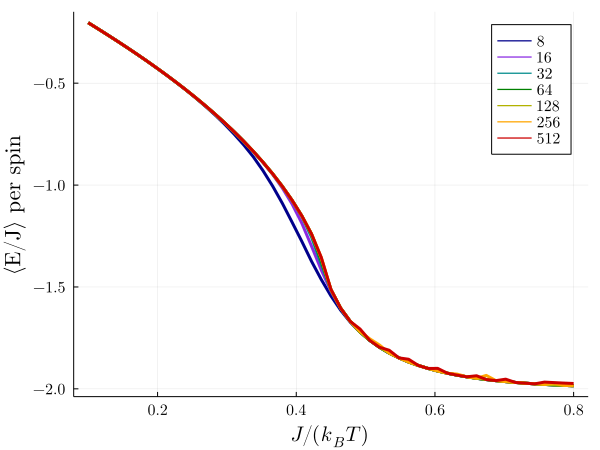

In [21]:
p = plot(βs, fullenergy ./ lengths.^2, labels=lengths, palette=:darktest,
    xlabel = L"J/(k_B T)", ylabel = "⟨E/J⟩ per spin")
savefig(p, figpath * "energy-full.pdf")
display(p)

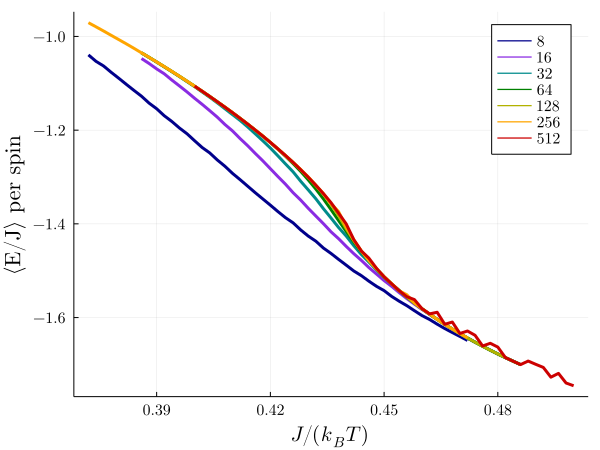

In [22]:
p = plot(zoomβ, zoomenergy ./ lengths.^2, labels=lengths, palette=:darktest,
    xlabel = L"J/(k_B T)", ylabel = "⟨E/J⟩ per spin")
savefig(p, figpath * "energy-zoom.pdf")
display(p)

### Magnetization

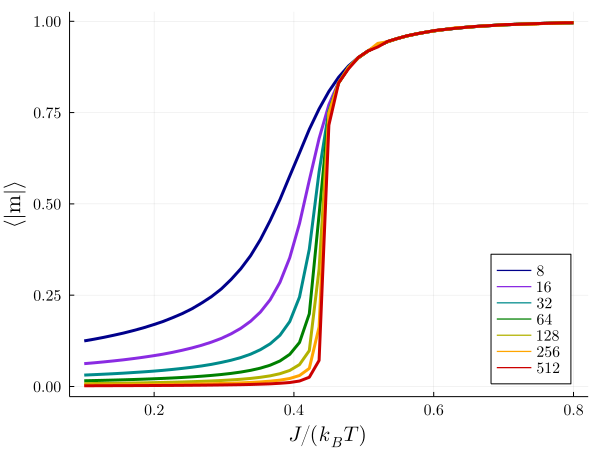

In [278]:
p = plot(βs, fullmag, labels=lengths, palette=:darktest, legend=:bottomright,
    xlabel = L"J/(k_B T)", ylabel = "⟨|m|⟩")
savefig(p, figpath * "magnetization-full.pdf")
display(p)

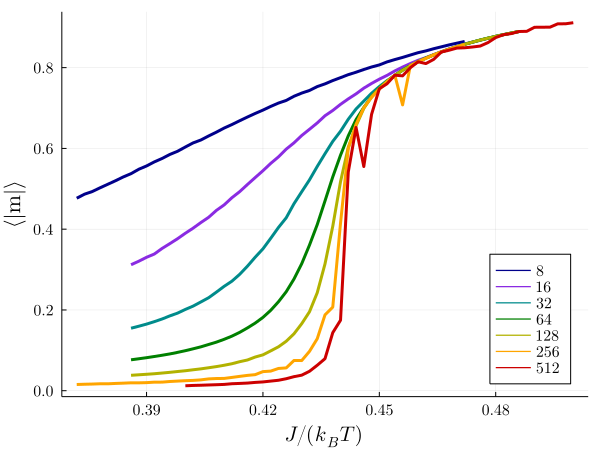

In [279]:
p = plot(zoomβ, zoommag, labels=lengths, palette=:darktest, legend=:bottomright,
    xlabel = L"J/(k_B T)", ylabel = "⟨|m|⟩")
savefig(p, figpath * "magnetization-zoom.pdf")
display(p)

### $C_V$

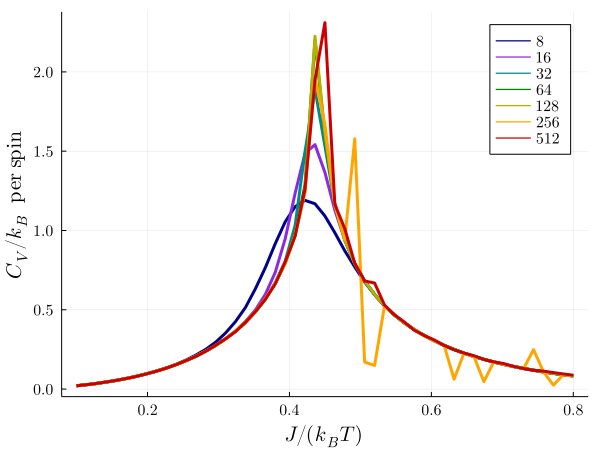

In [280]:
# smooth out the spiky 256 curve
for i in 26:βcount
    if fullCv[i, end-1] / 256^2 > 2.2
        fullCv[i, end-1] = fullCv[i, end-2]
    end
end

p = plot(βs, fullCv ./ lengths.^2, labels=lengths, palette=:darktest,
    xlabel = L"J/(k_B T)", ylabel = L"C_V/k_B\ \ \textrm{per\ spin}")
savefig(p, figpath * "Cv-full.pdf")
display(p)

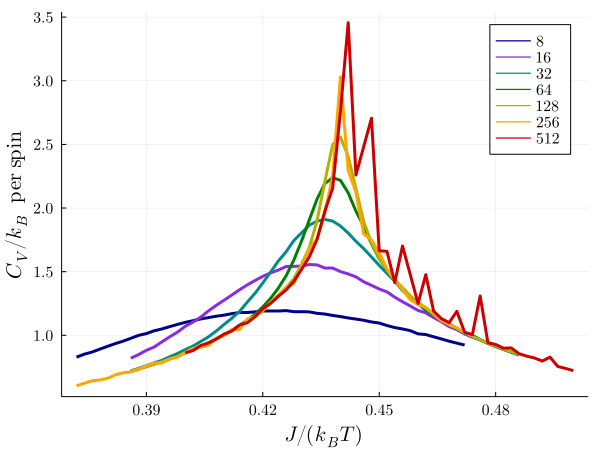

In [281]:
# smooth out the spiky 512 curve and the outlier in the 256 curve
for i in 1:βcount
    if zoomCv[i, end] / 512^2 > 4
        zoomCv[i, end] = (zoomCv[i - 1, end] + zoomCv[i + 1, end]) / 2
    end
    if zoomCv[i, end] / 512^2 < 0.5
        zoomCv[i, end] = (zoomCv[i - 1, end] + zoomCv[i + 1, end]) / 2
    end
    if zoomβ[i, end-1] > 0.45 && zoomCv[i, end-1] / 256^2 > 2.5
        zoomCv[i, end-1] = (zoomCv[i - 1, end - 1] + zoomCv[i + 1, end - 1]) / 2
    end
end

p = plot(zoomβ, zoomCv ./ lengths.^2, labels=lengths, palette=:darktest,
    xlabel = L"J/(k_B T)", ylabel = L"C_V/k_B\ \ \textrm{per\ spin}")
savefig(p, figpath * "Cv-zoom.pdf")
display(p)

### $\chi$

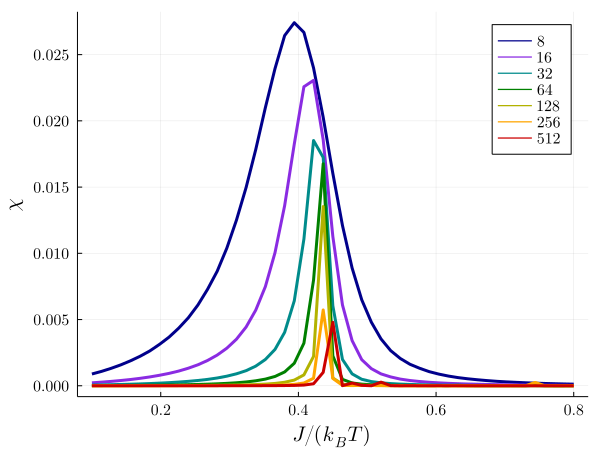

In [367]:
# smooth out the spiky 256 and 512 curves
for i in 1:βcount
    if fullχ[i, end-1] < 0
        fullχ[i, end-1] = fullχ[i, end-2]
    end
    if fullχ[i, end] < 0
        fullχ[i, end] = fullχ[i, end-2]
    end
end

p = plot(βs, fullχ, labels=lengths, palette=:darktest,
    xlabel = L"J/(k_B T)", ylabel = L"\chi")
savefig(p, figpath * "chi-full.pdf")
display(p)

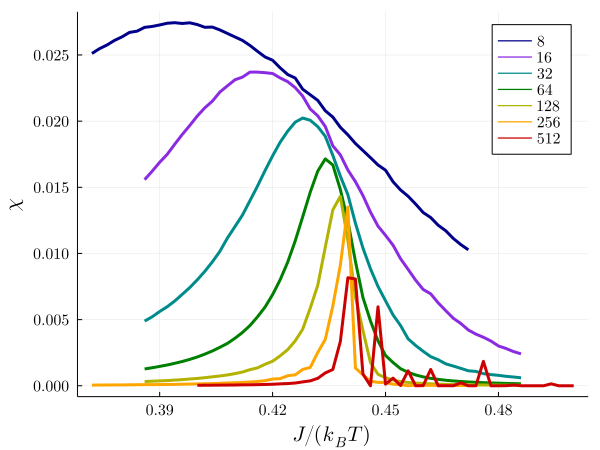

In [383]:
# remove the outliers in the 256 and 512 curves
for i in 1:βcount
    if zoomχ[i, end] > 0.02
        zoomχ[i, end] = 0
    end
    if zoomχ[i, end] < 0
        zoomχ[i, end] = 0
    end
    if zoomχ[i, end - 1] > 0.015
        zoomχ[i, end - 1] = 0
    end
end

p = plot(zoomβ, zoomχ, labels=lengths, palette=:darktest,
    xlabel = L"J/(k_B T)", ylabel = L"\chi")
savefig(p, figpath * "chi-zoom.pdf")
display(p)

### $\xi$

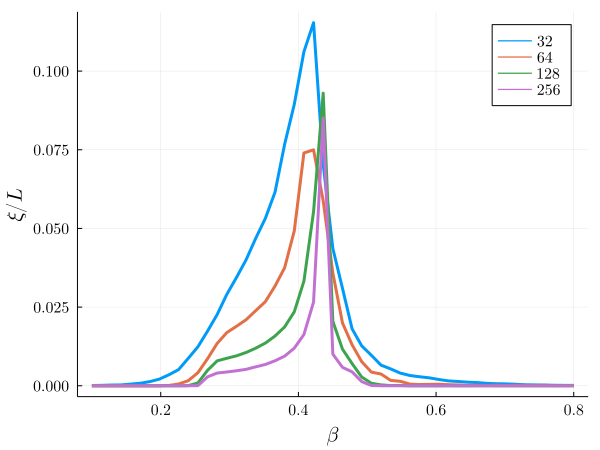

In [284]:
p = plot(βs, fullξ[:, 3:end - 1] ./ lengthsξ, labels=lengthsξ,
    xlabel = L"\beta", ylabel = L"\xi/L")
savefig(p, figpath * "xi-full.pdf")
display(p)

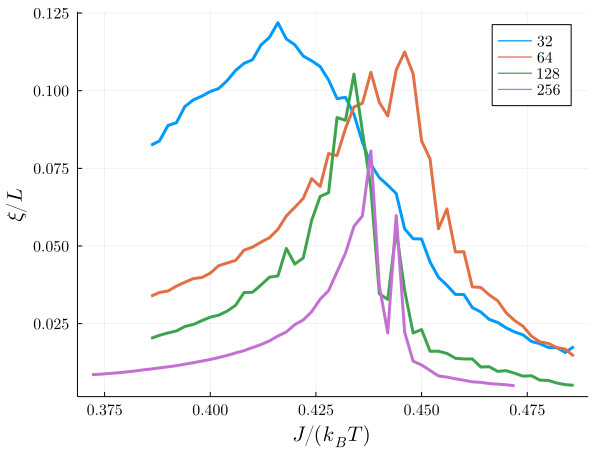

In [285]:
# remove the outliers
for i in 1:βcount
    for j in 3:6
        if zoomξ[i, j] ./ 2 ^ (j + 2) > 0.2
            zoomξ[i, j] = (zoomξ[i-1, j] + zoomξ[i+1, j]) / 2
        end
    end
end

p = plot(zoomβ[:, 3:end - 1], zoomξ[:, 3:end - 1] ./ lengthsξ, labels=lengthsξ,
    xlabel = L"J/(k_B T)", ylabel = L"\xi/L")
savefig(p, figpath * "xi-zoom.pdf")
display(p)

## Critical Exponents
The peculiarities of the data are taken into account

### Peaks

In [423]:
tempCv, tempχ, maxCv, maxχ, critm = [Vector{Float64}(undef, 7) for i in 1:5]
for i in 1:7
    peakCv = argmax(zoomCv[:, i])
    tempCv[i] = 1 / zoomβ[peakCv, i]
    maxCv[i] = zoomCv[peakCv, i]
    
    peakχ = argmax(zoomχ[:, i])
    tempχ[i] = 1 / zoomβ[peakχ, i]
    maxχ[i] = zoomχ[peakχ, i]

    critm[i] = zoommag[peakCv, i]
end
peakχ512 = argmax(zoomχ[:, 7])
tempχ[7] = 2 / (zoomβ[peakχ512, 7] + zoomβ[peakχ512 + 1, 7])

tempξ, maxξ = Vector{Float64}(undef, 4), Vector{Float64}(undef, 4)
for i in 3:6
    peakξ = argmax(zoomξ[:, i])
    tempξ[i-2] = 1 / zoomβ[peakξ, i]
    maxξ[i-2] = zoomχ[peakξ]
end
peakξ64 = argmax(fullξ[:, 4])
tempξ[2] = 1 / βs[peakξ64]
peakξ128 = argmax(fullξ[:, 5])
maxξ[3] = fullξ[peakξ128, 5]

11.9011499890046

### $\xi\sim|T_c-T|^{-\nu}$

In [424]:
L = [2^i for i in 5:8]
@. critfitfunc(x, p) = p[1] * abs(p[2] - x) ^ (-p[3])
fit = curve_fit(critfitfunc, tempξ, L, [1.0, 2.269, 1.0])
c, Tc∞, ν = coef(fit)[1], coef(fit)[2], coef(fit)[3]

(6.947592071214784, 2.264188716507016, 0.9088188241747006)

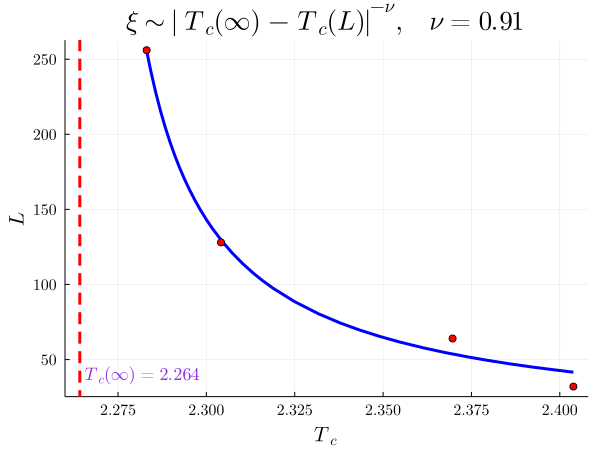

In [425]:
p = plot(x -> c * abs(Tc∞ - x) ^ (-ν), tempξ[end], tempξ[1], color=:blue, legend=false,
    title=L"\xi \sim |T_c(\infty) - T_c(L)|^{-\nu},\quad \nu = %$(round(ν, sigdigits=2))",
    ylabel=L"L", xlabel=L"T_c")
scatter!(p, tempξ, L, color=:red, ms=4)

vline!(p, [Tc∞], color=:red, linestyle=:dash)
annotetey = ylims(p)[1] + (ylims(p)[2] - ylims(p)[1]) / 15
annotatex = Tc∞ + (xlims(p)[2] - xlims(p)[1]) / 100
annotate!(p, annotatex, annotetey, text(L"T_c(\infty)=%$(round(Tc∞, sigdigits=4))",
    :blueviolet, :left, :dash, 12))

savefig(p, figpath * "fit-xi.pdf")
display(p)

### $C_V = c_0 \mathrm{ln}|T_c - T|$

In [426]:
L = [2^i for i in 3:9]
@. cvfitfunc(x, p) = p[1] * log(abs(p[2] - x))
fit = curve_fit(cvfitfunc, tempCv, maxCv ./ L.^2, [-6, 2.269])
c0, Tc∞ = coef(fit)[1], coef(fit)[2]

(-0.5601268252767827, 2.2646709129270697)

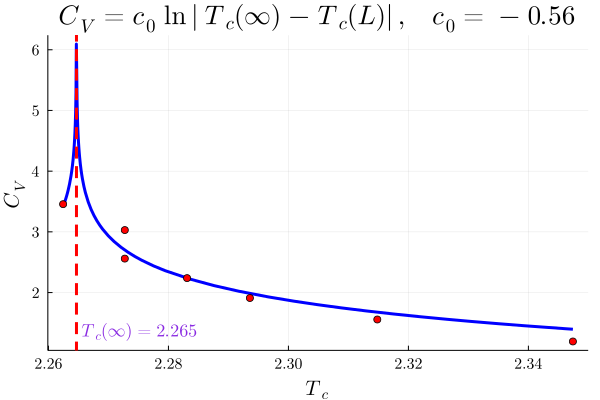

In [427]:
p = plot(x -> c0 * log(abs(Tc∞ - x)), tempCv[end], tempCv[1], color=:blue, legend=false,
    title=L"C_V = c_0\ \mathrm{ln}\ |T_c(\infty) - T_c(L)|,\quad c_0 = %$(round(c0, sigdigits=2))",
    ylabel=L"C_V", xlabel=L"T_c", size=(600, 400))
scatter!(p, tempCv, maxCv ./ L.^2, color=:red, ms=4)

vline!(p, [Tc∞], color=:red, linestyle=:dash)
annotetey = ylims(p)[1] + (ylims(p)[2] - ylims(p)[1]) / 15
annotatex = Tc∞ + (xlims(p)[2] - xlims(p)[1]) / 100
annotate!(p, annotatex, annotetey, text(L"T_c(\infty)=%$(round(Tc∞, sigdigits=4))",
    :blueviolet, :left, :dash, 12))

savefig(p, figpath * "fit-Cv.pdf")
display(p)

### $\chi\sim|T_c-T|^{-\gamma}$

In [449]:
L = [2^i for i in 3:9]
@. critfitfunc(x, p) = p[1] * abs(p[2] - x) ^ (-p[3])
# omitted final χ because it is not accurate
fit = curve_fit(critfitfunc, tempχ[1:6], maxχ[1:6] .* L[1:6].^2, [0.1, 2.269, 7/4])
c, Tc∞, γ = coef(fit)[1], coef(fit)[2], coef(fit)[3]

(0.2823780859013425, 2.263927782299685, 1.7008438954787133)

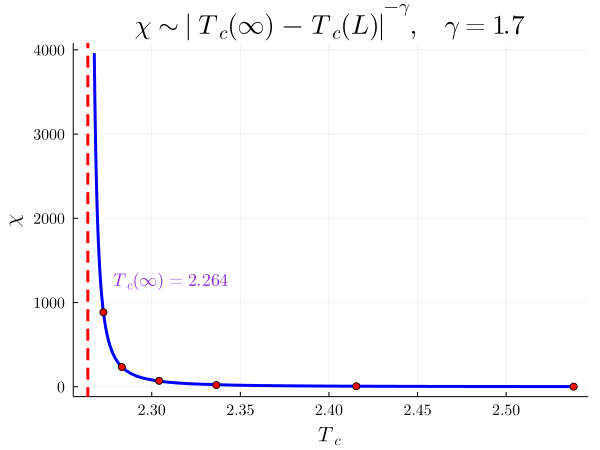

In [450]:
p = plot(x -> c * abs(Tc∞ - x) ^ (-γ), tempχ[end], tempχ[1], color=:blue, legend=false,
    title=L"\chi \sim |T_c(\infty) - T_c(L)|^{-\gamma},\quad \gamma = %$(round(γ, sigdigits=3))",
    ylabel=L"\chi", xlabel=L"T_c")
scatter!(p, tempχ[1:6], maxχ[1:6] .* L[1:6].^2, color=:red, ms=4)

vline!(p, [Tc∞], color=:red, linestyle=:dash)
annotetey = ylims(p)[1] + (ylims(p)[2] - ylims(p)[1]) / 3
annotatex = Tc∞ + (xlims(p)[2] - xlims(p)[1]) / 20
annotate!(p, annotatex, annotetey, text(L"T_c(\infty)=%$(round(Tc∞, sigdigits=4))",
    :blueviolet, :left, :dash, 12))

savefig(p, figpath * "fit-chi.pdf")
display(p)

### $\langle|m|\rangle\sim|T_c-T|^\beta$

In [430]:
L = [2^i for i in 3:9]
@. critfitfunc(x, p) = p[1] * abs(p[2] - x) ^ (p[3])
fit = curve_fit(critfitfunc, tempCv, critm, [1.0, 2.269, 1/8])
c, Tc∞, β = coef(fit)[1], coef(fit)[2], coef(fit)[3]

(0.9581939671026611, 2.270155404833505, 0.12354733873972873)

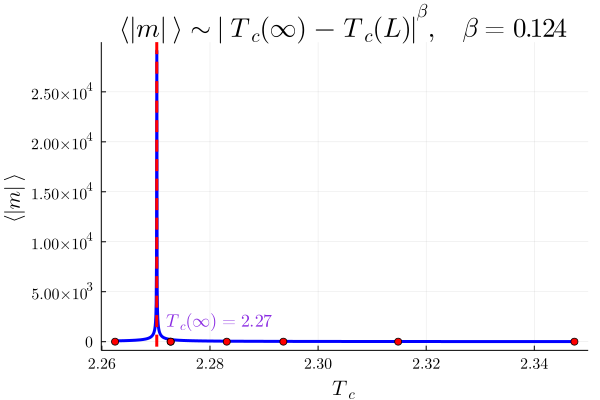

In [443]:
p = plot(x -> c * abs(Tc∞ - x) ^ (-ν), tempCv[end], tempCv[1], color=:blue, legend=false,
    title=L"\langle\|m\|\rangle \sim |T_c(\infty) - T_c(L)|^\beta,\quad  \beta = %$(round(β, sigdigits=3))",
    ylabel=L"\langle\|m\|\rangle", xlabel=L"T_c")
scatter!(p, tempCv, critm, color=:red, ms=4, size=(600, 400))

vline!(p, [Tc∞], color=:red, linestyle=:dash)
annotetey = ylims(p)[1] + (ylims(p)[2] - ylims(p)[1]) / 10
annotatex = Tc∞ + (xlims(p)[2] - xlims(p)[1]) / 50
annotate!(p, annotatex, annotetey, text(L"T_c(\infty)=%$(round(Tc∞, sigdigits=4))",
    :blueviolet, :left, :dash, 12))

savefig(p, figpath * "fit-magnetization.pdf")
display(p)